In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

In [4]:
df_train =  pd.read_csv('train_preprocessed.csv')
df_test = pd.read_csv('test_preprocessed.csv')

In [5]:
df_train.processed = df_train.processed.apply(lambda x: x.replace('_', ' '))

In [6]:
df_test.processed = df_test.processed.apply(lambda x: x.replace('_', ' '))

In [7]:
df_train.sample(5)

,label,processed
57318,__label__12.0,cột tóc preciosa
62908,__label__12.0,túi xách cuci
23132,__label__14.0,đèn đọc sách kvart
26635,__label__14.0,kệ sách
17360,__label__11.0,mặt nạ the saem


In [8]:
df_test.sample(5)

,label,processed
7035,__label__24.0,đồ chơi benrikids
10315,__label__1.0,ốp lưng silicon huawei
12069,__label__1.0,tai nghe lighting hoco
10091,__label__1.0,tai nghe smartphone hoco
16118,__label__1.0,máy bay cánh


In [9]:
CV = TfidfVectorizer(max_df=0.9,
                     min_df=3,
#                      ngram_range=(1, 2),
#                      max_features=5000
                    )
lbencoder = LabelEncoder()

In [10]:
X_train = CV.fit_transform(df_train.processed)
y_train = lbencoder.fit_transform(df_train.label)
X_test = CV.transform(df_test['processed'])
y_test = lbencoder.transform(df_test['label'])

In [10]:
X_train.shape

(87438, 9365)

In [11]:
param_grid = [
{'n_estimators': [10, 30], 'max_features': [.5, .7, .9], 'class_weight':['balanced']}, 
# {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4], 'class_weight':['balanced']},
]
RF = RandomForestClassifier()

In [ ]:
%%time
gsCV = GridSearchCV(RF, param_grid=param_grid, cv=5, scoring='f1_macro', return_train_score=True, verbose=3, n_jobs=-1)
gsCV.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


In [ ]:
gsCV.best_estimator_

In [ ]:
gsCV.best_score_

In [14]:
from sklearn.base import clone

In [13]:
kfold = StratifiedKFold(n_splits=5, random_state=2)

In [ ]:
%%time
for train_index, test_index in kfold.split(X_train, y_train):
    clone_clf = clone(RF)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train[test_index])
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    print(f1_score(y_test_fold, y_pred, average='macro')) 

In [ ]:
gsCV.cv_results_

In [ ]:
%%time
RF = RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_features=0.5,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=50, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
RF.fit(X_train, y_train)

In [ ]:
y_test_pred = RF.predict(X_test)
y_train_pred = RF.predict(X_train)
print('\033[5;33;40m'+'*'*62+f"\n{'*'*17:20} \033[0;0m{'test set':^20}\033[5;33;40m {'*'*17:>20}\n{'*'*62}\n\033[5;33;47m")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_test_pred), index = lbencoder.classes_,
                  columns = lbencoder.classes_)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='d')
print(classification_report(y_test,  y_test_pred,  target_names=lbencoder.inverse_transform(range(7))))

plt.show()
print('\033[5;37;40m'+'*'*62+f"\n{'*'*17:20} {'train set':^20} {'*'*17:>20}\n{'*'*62}\n")
print(classification_report(y_train,  y_train_pred,  target_names=lbencoder.inverse_transform(range(7))))
df_cm = pd.DataFrame(confusion_matrix(y_train, y_train_pred), index = lbencoder.classes_,
                  columns = lbencoder.classes_)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='d')
plt.show()



In [33]:
%%time
for alpha in [0.001, 0.01, 0.1, 1, 10]:
    print('\033[1;33malpha='+str(alpha)+'\033[0;35m')
    f1_test, f1_train=[], []
    lgt = MultinomialNB(alpha=alpha)
    for train_index, test_index in kfold.split(X_train, y_train):
        clone_clf = clone(lgt)
        X_train_folds = X_train[train_index]
        y_train_folds = (y_train[train_index])
        X_test_fold = X_train[test_index]
        y_test_fold = (y_train[test_index])
        clone_clf.fit(X_train_folds, y_train_folds)
        y_pred = clone_clf.predict(X_test_fold)
        f1_test.append(f1_score(y_test_fold, y_pred, average='macro'))
        f1_train.append(f1_score(y_train_folds, clone_clf.predict(X_train_folds), average='macro'))
    for pair in zip(f1_test, f1_train):
        print(pair)
    print('-'*30)
    print(np.mean(f1_test), np.mean(f1_train))
    print('\n')

alpha=0.001
(0.8134016220363814, 0.8748725835099916)
(0.7853802856931595, 0.8846768460588945)
(0.7253702517541789, 0.8859853366707172)
(0.7478095041920655, 0.8888585557827712)
(0.7312996714880392, 0.8900031854011587)
------------------------------
0.760652267032765 0.8848793014847066


alpha=0.01
(0.8208940516107666, 0.8745965584756519)
(0.7920899341981527, 0.8841040698451582)
(0.7330874204216057, 0.8852193617096668)
(0.7523617926138384, 0.8892764491579909)
(0.7409218850591631, 0.8890103642799067)
------------------------------
0.7678710167807052 0.884441360693675


alpha=0.1
(0.8328591262699482, 0.8672857173023859)
(0.8015166827276967, 0.8784606674425743)
(0.74414371077896, 0.8801639827740259)
(0.7644230298501752, 0.882922222009471)
(0.7581751796593006, 0.8836911400736759)
------------------------------
0.7802235458572161 0.8785047459204266


alpha=1
(0.7795519840154792, 0.7988585889844629)
(0.7389934579461148, 0.8097160294959341)
(0.7128747009796635, 0.8070782776718268)
(0.7134917295

c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted 

(0.5474788714128301, 0.5598711924323369)
(0.5412765711615487, 0.5682216666425047)
(0.5257161323219856, 0.5657328323675614)
(0.5266995570013386, 0.571902265553414)
(0.523094314820196, 0.5739118195422627)
------------------------------
0.5328530893435798 0.567927955307616


Wall time: 1.78 s


c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [34]:
nvbs = MultinomialNB(alpha=0.1)

In [35]:
%%time
nvbs.fit(X_train, y_train)

Wall time: 31.9 ms


MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

**************************************************************
*****************          test set          *****************
**************************************************************

               precision    recall  f1-score   support

 __label__1.0       0.88      0.89      0.88      5023
__label__11.0       0.85      0.84      0.84      1739
__label__12.0       0.84      0.92      0.88      6203
__label__14.0       0.78      0.80      0.79      4059
__label__16.0       0.92      0.75      0.83       316
__label__24.0       0.74      0.42      0.54      1341
 __label__9.0       0.76      0.65      0.70       498

     accuracy                           0.83     19179
    macro avg       0.82      0.75      0.78     19179
 weighted avg       0.83      0.83      0.83     19179



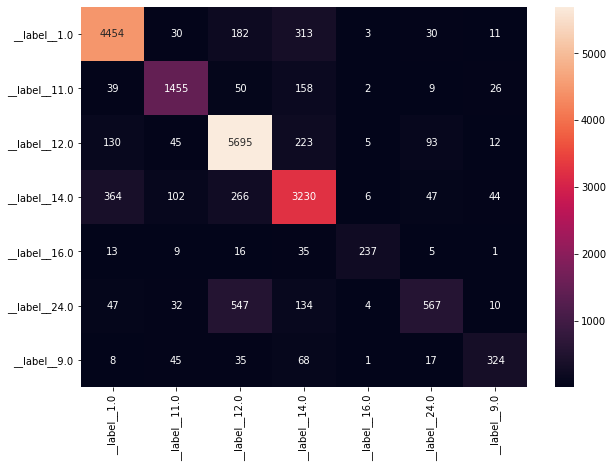

**************************************************************
*****************         train set          *****************
**************************************************************

               precision    recall  f1-score   support

 __label__1.0       0.91      0.91      0.91     17306
__label__11.0       0.92      0.92      0.92     13883
__label__12.0       0.91      0.96      0.93     20734
__label__14.0       0.87      0.90      0.88     22504
__label__16.0       0.94      0.73      0.82      1586
__label__24.0       0.90      0.72      0.80      6316
 __label__9.0       0.89      0.82      0.86      5109

     accuracy                           0.90     87438
    macro avg       0.90      0.85      0.87     87438
 weighted avg       0.90      0.90      0.90     87438



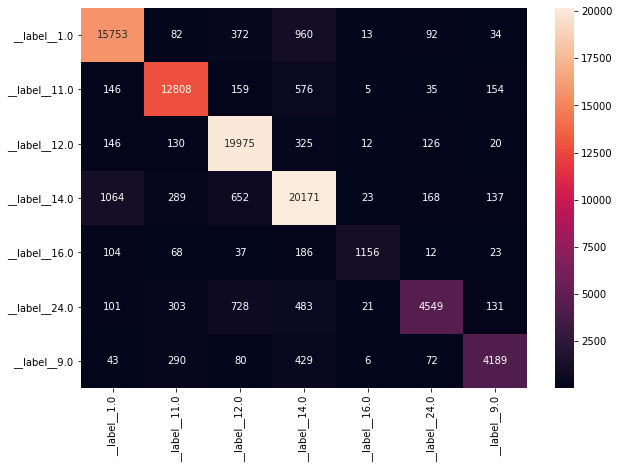

In [36]:
y_test_pred = nvbs.predict(X_test)
y_train_pred = nvbs.predict(X_train)

print('\033[5;33;40m'+'*'*62+f"\n{'*'*17:20} {'test set':^20} {'*'*17:>20}\n{'*'*62}\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_test_pred), index = lbencoder.classes_,
                  columns = lbencoder.classes_)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='d')
print(classification_report(y_test,  y_test_pred,  target_names=lbencoder.inverse_transform(range(7))))

plt.show()

print('\033[5;33;40m'+'*'*62+f"\n{'*'*17:20} {'train set':^20} {'*'*17:>20}\n{'*'*62}\n")
print(classification_report(y_train,  y_train_pred,  target_names=lbencoder.inverse_transform(range(7))))
df_cm = pd.DataFrame(confusion_matrix(y_train, y_train_pred), index = lbencoder.classes_,
                  columns = lbencoder.classes_)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='d')
plt.show()



In [ ]:
# from sklearn.preprocessing import 

In [25]:
param_grid = [
{'penalty':['l2', 'none'], 'C':[0.1, 1, 10], 'solver':['lbfgs', 'newton-cg'], 'max_iter':[10000], 'class_weight':['balanced']}, 
]
lgt = LogisticRegression()

In [ ]:
%%time
gsCV = GridSearchCV(lgt, param_grid=param_grid, cv=5, scoring='f1_macro', return_train_score=True, verbose=3, n_jobs=-1)
gsCV.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


In [31]:
%%time
for C in [0.1, 1, 10]:
    print('\033[1;33mC='+str(C)+'\033[0;35m')
    f1_test, f1_train=[], []
    lgt = LogisticRegression(solver='lbfgs', penalty='l2', C=C, multi_class='auto', max_iter=10000, class_weight='balanced')

    for train_index, test_index in kfold.split(X_train, y_train):
        clone_clf = clone(lgt)
        X_train_folds = X_train[train_index]
        y_train_folds = (y_train[train_index])
        X_test_fold = X_train[test_index]
        y_test_fold = (y_train[test_index])
        clone_clf.fit(X_train_folds, y_train_folds)
        y_pred = clone_clf.predict(X_test_fold)
        f1_test.append(f1_score(y_test_fold, y_pred, average='macro'))
        f1_train.append(f1_score(y_train_folds, clone_clf.predict(X_train_folds), average='macro'))
    for pair in zip(f1_test, f1_train):
        print(pair)
    print('-'*30)
    print(np.mean(f1_test), np.mean(f1_train))
    print('\n')

C=0.1
(0.765040499360678, 0.7779069728484976)
(0.7426987847248745, 0.7961438394252086)
(0.7508233572283801, 0.7949296850971389)
(0.6979459110481855, 0.7984011527916639)
(0.699711335277379, 0.8001825319982548)
------------------------------
0.7312439775278994 0.7935128364321528


C=1
(0.8196146998638906, 0.8580609750391046)
(0.7879507245582832, 0.8705164330084477)
(0.7775679960747474, 0.8701059321726811)
(0.7503594313640062, 0.8738366846060798)
(0.7515349203289812, 0.8773941778433298)
------------------------------
0.7774055544379816 0.8699828405339286


C=10
(0.8210196515003546, 0.8884128437008553)
(0.7881537487800544, 0.9004946198298801)
(0.7686210671099427, 0.9021887215989892)
(0.7506232525905246, 0.9029673350642947)
(0.7474094859747976, 0.9060264280041356)
------------------------------
0.7751654411911348 0.9000179896396311


Wall time: 4min 39s


In [30]:
%%time
print('solver newton-cg')
for C in [0.1, 1, 10]:
    print('\033[1;33mC='+str(C)+'\033[0;35m')
    f1_test, f1_train=[], []
    lgt = LogisticRegression(solver='newton-cg', penalty='l2', C=C, multi_class='auto', max_iter=10000, class_weight='balanced')

    for train_index, test_index in kfold.split(X_train, y_train):
        clone_clf = clone(lgt)
        X_train_folds = X_train[train_index]
        y_train_folds = (y_train[train_index])
        X_test_fold = X_train[test_index]
        y_test_fold = (y_train[test_index])
        clone_clf.fit(X_train_folds, y_train_folds)
        y_pred = clone_clf.predict(X_test_fold)
        f1_test.append(f1_score(y_test_fold, y_pred, average='macro'))
        f1_train.append(f1_score(y_train_folds, clone_clf.predict(X_train_folds), average='macro'))
    for pair in zip(f1_test, f1_train):
        print(pair)
    print('-'*30)
    print(np.mean(f1_test), np.mean(f1_train))
    print('\n')

solver newton-cg
C=0.1
(0.765040499360678, 0.7779069728484976)
(0.7427163674890258, 0.7961438394252086)
(0.7508233572283801, 0.7949791328949638)
(0.6979459110481855, 0.7983830954026996)
(0.6996106554958088, 0.8000944486317777)
------------------------------
0.7312273581244156 0.7935014978406294


C=1
(0.8197323051096818, 0.8581010413370012)
(0.7879947089633268, 0.8704421532289537)
(0.7775333427436593, 0.8700901508112049)
(0.7503594313640062, 0.8738366846060798)
(0.7515349203289812, 0.8773685220886142)
------------------------------
0.777430941701931 0.8699677104143706


C=10
(0.8210946273433525, 0.8883828358470758)
(0.7882936500426467, 0.900503916991199)
(0.7686210671099427, 0.9022082469301533)
(0.7506771321262763, 0.9029129285049953)
(0.7473636667979618, 0.9059990663692007)
------------------------------
0.7752100286840359 0.9000013989285248


Wall time: 1min 53s


In [26]:
%%time
for solver in ['lbfgs', 'newton-cg']:
    print('\033[4m'+str(solver)+' no penalty\033[0;0m\n')
    f1_test, f1_train=[], []
    for train_index, test_index in kfold.split(X_train, y_train):        
        clone_clf = clone(LogisticRegression(solver=solver, multi_class='auto', max_iter=10000, class_weight='balanced'))
        X_train_folds = X_train[train_index]
        y_train_folds = (y_train[train_index])
        X_test_fold = X_train[test_index]
        y_test_fold = (y_train[test_index])
        clone_clf.fit(X_train_folds, y_train_folds)
        y_pred = clone_clf.predict(X_test_fold)
        f1_test.append(f1_score(y_test_fold, y_pred, average='macro'))
        f1_train.append(f1_score(y_train_folds, clone_clf.predict(X_train_folds), average='macro'))
    for pair in zip(f1_test, f1_train):
        print(pair)
    print('-'*30)
    print(np.mean(f1_test), np.mean(f1_train))
    print('\n')

lbfgs none penalty

(0.8196146998638906, 0.8580609750391046)
(0.7879507245582832, 0.8705164330084477)
(0.7775679960747474, 0.8701059321726811)
(0.7503594313640062, 0.8738366846060798)
(0.7515349203289812, 0.8773941778433298)
------------------------------
0.7774055544379816 0.8699828405339286
newton-cg none penalty

(0.8197323051096818, 0.8581010413370012)
(0.7879947089633268, 0.8704421532289537)
(0.7775333427436593, 0.8700901508112049)
(0.7503594313640062, 0.8738366846060798)
(0.7515349203289812, 0.8773685220886142)
------------------------------
0.777430941701931 0.8699677104143706
Wall time: 1min 52s


In [37]:
lgt = LogisticRegression(solver='lbfgs', penalty='l2', C=1, multi_class='auto', max_iter=10000, class_weight='balanced')

In [38]:
%%time
lgt.fit(X_train, y_train)

Wall time: 19.4 s


LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

**************************************************************
*****************          test set          *****************
**************************************************************

               precision    recall  f1-score   support

 __label__1.0       0.89      0.89      0.89      5023
__label__11.0       0.85      0.84      0.84      1739
__label__12.0       0.88      0.86      0.87      6203
__label__14.0       0.81      0.76      0.78      4059
__label__16.0       0.40      0.86      0.55       316
__label__24.0       0.61      0.56      0.58      1341
 __label__9.0       0.58      0.79      0.67       498

     accuracy                           0.82     19179
    macro avg       0.72      0.79      0.74     19179
 weighted avg       0.83      0.82      0.82     19179



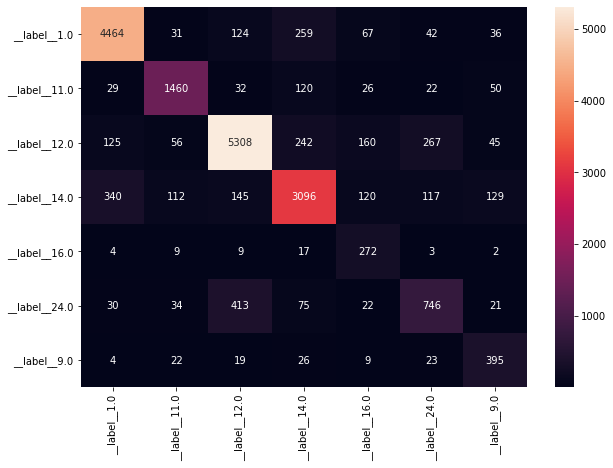

**************************************************************
*****************         train set          *****************
**************************************************************

               precision    recall  f1-score   support

 __label__1.0       0.92      0.90      0.91     17306
__label__11.0       0.93      0.91      0.92     13883
__label__12.0       0.93      0.94      0.94     20734
__label__14.0       0.92      0.85      0.88     22504
__label__16.0       0.62      0.95      0.75      1586
__label__24.0       0.78      0.83      0.81      6316
 __label__9.0       0.80      0.92      0.86      5109

     accuracy                           0.90     87438
    macro avg       0.84      0.90      0.87     87438
 weighted avg       0.90      0.90      0.90     87438



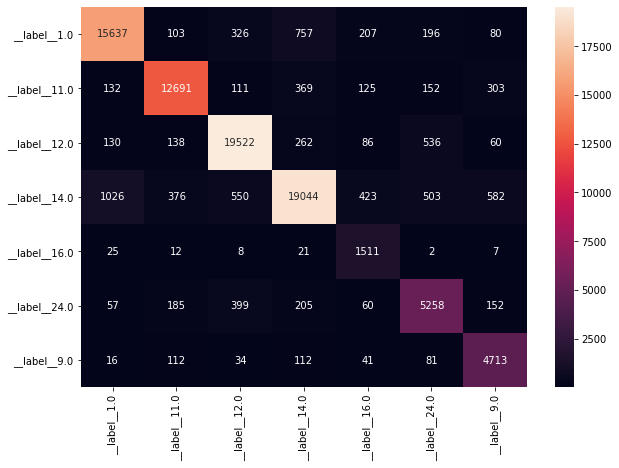

In [39]:
y_test_pred = lgt.predict(X_test)
y_train_pred = lgt.predict(X_train)

print('\033[5;33;40m'+'*'*62+f"\n{'*'*17:20} {'test set':^20} {'*'*17:>20}\n{'*'*62}\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_test_pred), index = lbencoder.classes_,
                  columns = lbencoder.classes_)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='d')
print(classification_report(y_test,  y_test_pred,  target_names=lbencoder.inverse_transform(range(7))))

plt.show()

print('\033[5;33;40m'+'*'*62+f"\n{'*'*17:20} {'train set':^20} {'*'*17:>20}\n{'*'*62}\n")
print(classification_report(y_train,  y_train_pred,  target_names=lbencoder.inverse_transform(range(7))))
df_cm = pd.DataFrame(confusion_matrix(y_train, y_train_pred), index = lbencoder.classes_,
                  columns = lbencoder.classes_)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='d')
plt.show()

